In [1]:
#pip install pyspark

In [2]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
import pandas as pd
import numpy as np
import pyspark
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE 
#from sklearn.preprocessing import RobustScaler
import pandas as pd
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum,avg,max,count
from pyspark.sql.functions import col, asc,desc
import plotly.express as px
import math   
from sklearn.feature_selection import mutual_info_regression


Creating the spark session




In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [4]:
#present working directory

In [5]:
pwd

'/content'

In [6]:
sparkDF=spark.read.option("delimiter", ",").option("header",True).option("inferSchema",True).csv("salary.csv")

print("The columns are   ",sparkDF.columns)

The columns are    ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']


 
 *Printing all the unique rows*

In [7]:
for i in sparkDF.columns:
    print("The count for each category in the attribute::: \n\n"+i)
    sparkDF.groupBy(i).agg(count("*").alias("count_of_each")).orderBy(col("count_of_each").desc()).show()
    print("\n\n\n")


The count for each category in the attribute::: 

age
+---+-------------+
|age|count_of_each|
+---+-------------+
| 36|          898|
| 31|          888|
| 34|          886|
| 23|          877|
| 35|          876|
| 33|          875|
| 28|          867|
| 30|          861|
| 37|          858|
| 25|          841|
| 27|          835|
| 32|          828|
| 38|          827|
| 39|          816|
| 29|          813|
| 41|          808|
| 24|          798|
| 40|          794|
| 26|          785|
| 42|          780|
+---+-------------+
only showing top 20 rows





The count for each category in the attribute::: 

workclass
+-----------------+-------------+
|        workclass|count_of_each|
+-----------------+-------------+
|          Private|        22696|
| Self-emp-not-inc|         2541|
|        Local-gov|         2093|
|                ?|         1836|
|        State-gov|         1298|
|     Self-emp-inc|         1116|
|      Federal-gov|          960|
|      Without-pay|           14|
| 

*converting Spark dataframe to pandas Dataframe*

In [8]:
df=sparkDF.toPandas()
df.shape


(32561, 15)

*Printing unique rows (pandas)*

In [9]:
for col in df.columns.values:
    print('__'+col+'__', end="*\n\n")
    print(df[col].unique(), end="\n\n ~~\n")

__age__*

[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]

 ~~
__workclass__*

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

 ~~
__fnlwgt__*

[ 77516  83311 215646 ...  34066  84661 257302]

 ~~
__education__*

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

 ~~
__education-num__*

[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]

 ~~
__marital-status__*

[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

 ~~
__occupation__*

[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sa

# **Preprocessing**


In [10]:
df.salary.unique()


array([' <=50K', ' >50K'], dtype=object)

In [11]:
## calculating null
print("Before converting '?' to null- \n\n",df.isnull().sum())
df['workclass'] = df['workclass'].replace(' ?', np.nan)
df['occupation'] = df['occupation'].replace(" ?", np.nan)
df['native-country'] = df['native-country'].replace(" ?", np.nan)



Before converting '?' to null- 

 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64


---
---
Geting the most frequent workclass and most frequent occupation in that class






In [12]:
print("The most frequent workclass is ",df['workclass'].mode())
temp = df['occupation'][df['workclass']==' Private']
print("Most frequent occupation in the workclass ", df['workclass'].mode(), 'is ',temp.mode())



The most frequent workclass is  0     Private
dtype: object
Most frequent occupation in the workclass  0     Private
dtype: object is  0     Craft-repair
dtype: object


---
---
 Imputing the null values with the most frequent 

In [13]:

df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['workclass'].isnull().sum()
df['occupation'].fillna(' Craft-repair', inplace=True)
df['occupation'].isnull().sum()


#most Frequent native-country
df['native-country'].fillna(df['native-country'].mode()[0], inplace=True)
df['native-country'].isnull().sum()


0

In [14]:
print("\n\nAfter converting '?' to null- \n\n",df.isnull().sum())




After converting '?' to null- 

 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64


---
---



*Deleting duplicate rows*

In [15]:
print("Total number of duplicate rows are ",df.duplicated().sum())
df.drop_duplicates(keep='first',inplace=True)

Total number of duplicate rows are  24


In [16]:
df.duplicated().sum()

0

In [17]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# **Exploratory data analysis**

---
---



*AGE Distribution*

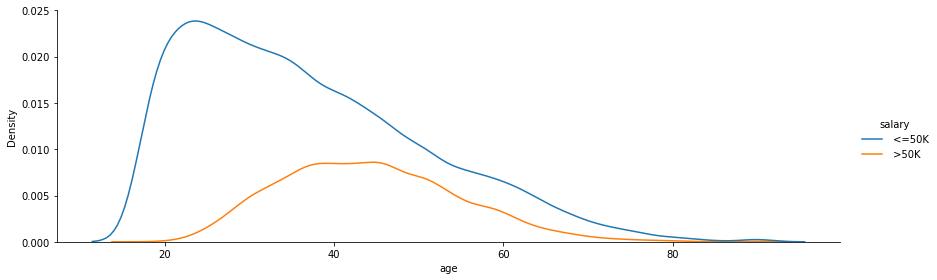

In [18]:
sns.displot(data=df, x="age", hue="salary", kind="kde", height=4, aspect=3)

---
---



*hours-per-week distribution for the two classes of salary*

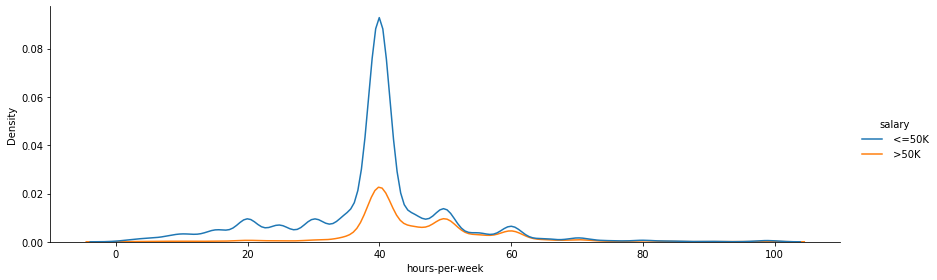

In [19]:
sns.displot(data=df, x="hours-per-week", hue="salary", kind="kde", height=4, aspect=3)

---
---

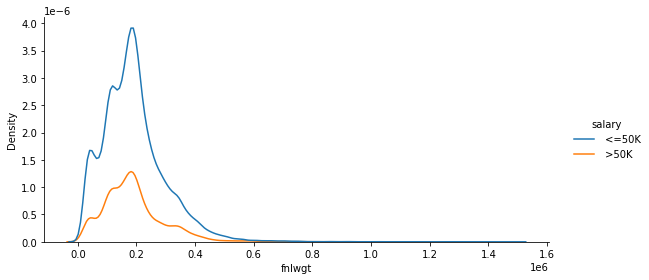

In [20]:
sns.displot(data=df, x="fnlwgt", hue="salary", kind="kde", height=4, aspect=2)

We understand that the final weight(number of people the census believes the entry represents) has a skewed data. We would be using oversampling

---
---

*Workclass Distribution*



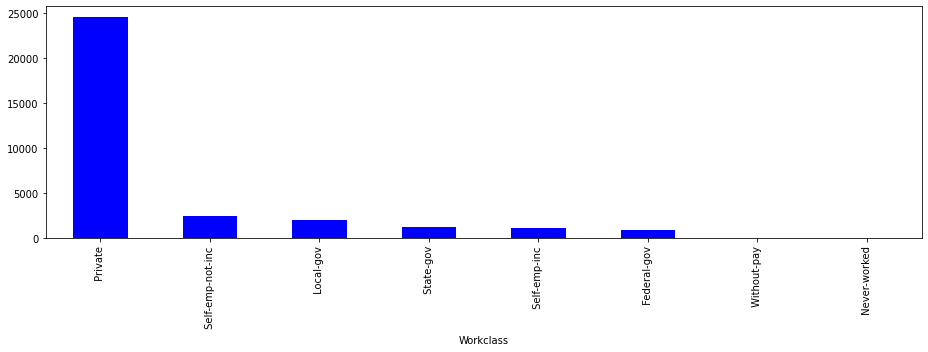

In [21]:
plt.figure(figsize=(13,5))
df.workclass.value_counts().plot(kind="bar", color="blue")
plt.xlabel("Workclass")
plt.tight_layout()
plt.show()

---
---
Comparing education vs Education-num

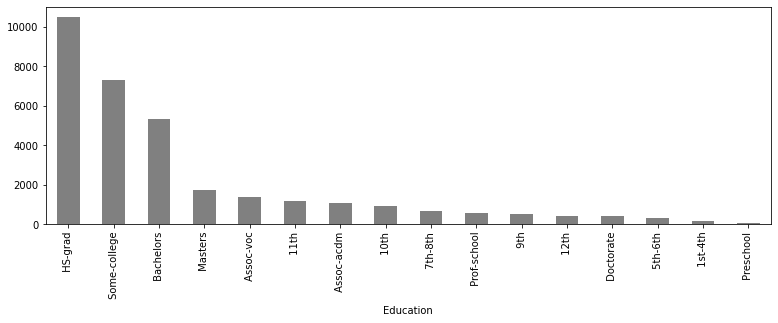

In [22]:

plt.figure(figsize=(13,4))
df['education'].value_counts().plot(kind='bar', color = "grey")
plt.xlabel("Education")
plt.show()


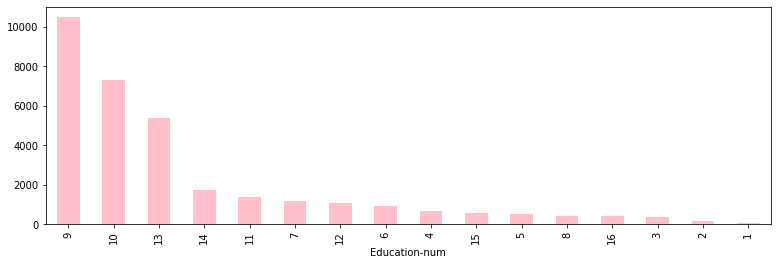

In [23]:

plt.figure(figsize=(13,4))
df['education-num'].value_counts().plot(kind='bar', color = "pink")
plt.xlabel("Education-num")
plt.show()

We understand that both education and education-num are the same. Education-num is a higher for a higher educated person. So we dont have to convert education into categorical data using labelEncoding. We can use education-num directly and drop education.

---
---
*Distribution education-num *

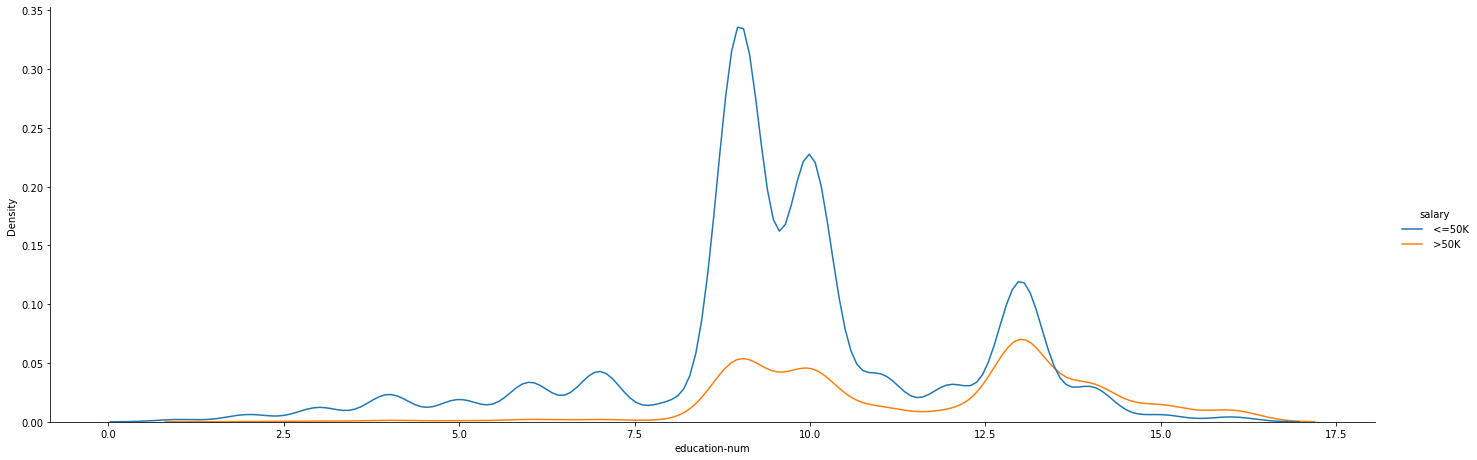

In [24]:
sns.displot(data=df, x="education-num", hue="salary", kind="kde", height=6.5, aspect=3)

---
---
Total distribution of education-num 

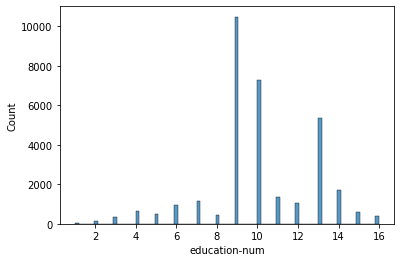

In [25]:
sns.histplot(data=df, x="education-num")

---
---
Function for the getting percentage distribution for different categories

In [26]:
def getBarPercent (plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.0f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

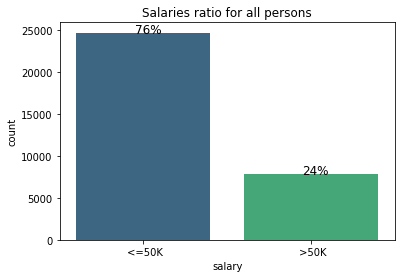

In [27]:
plt.figure(figsize=(6,4))
ax = sns.countplot( x=df.salary , data= df , palette='viridis')
ax.set_title('Salaries ratio for all persons')
getBarPercent(ax , df.salary)

We would have to handle this unbalanced Data

---
---
*Male vs Female distribution of salary*

Text(0.5, 1.0, 'Salaries ratio for Male/Female')

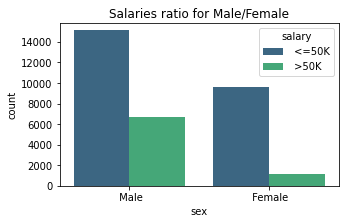

In [28]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='sex', hue='salary', palette='viridis').set_title('Salaries ratio for Male/Female')

---
---
*Distribution of salaries for different  for races

Text(0.5, 1.0, 'Race VS Salary')

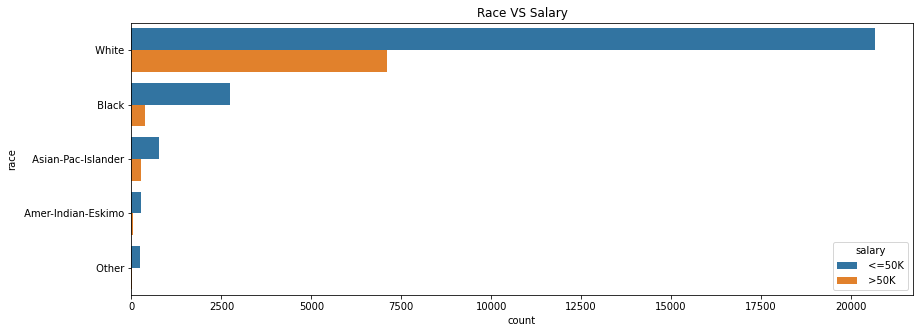

In [29]:

plt.figure(figsize=(14, 5))
ax = sns.countplot(data=df,y='race', hue='salary')
sns.set_palette('Accent_r')
ax.set_title('Race VS Salary')

We can see that the total data is from race of white in general. Our results might be skewed if we use race for the machine learning.

In [30]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

---
---
*Bar plot for various Workclasses in the 2 salary cateogories*

Text(0.5, 1.0, 'Salaries ratio for Occupation')

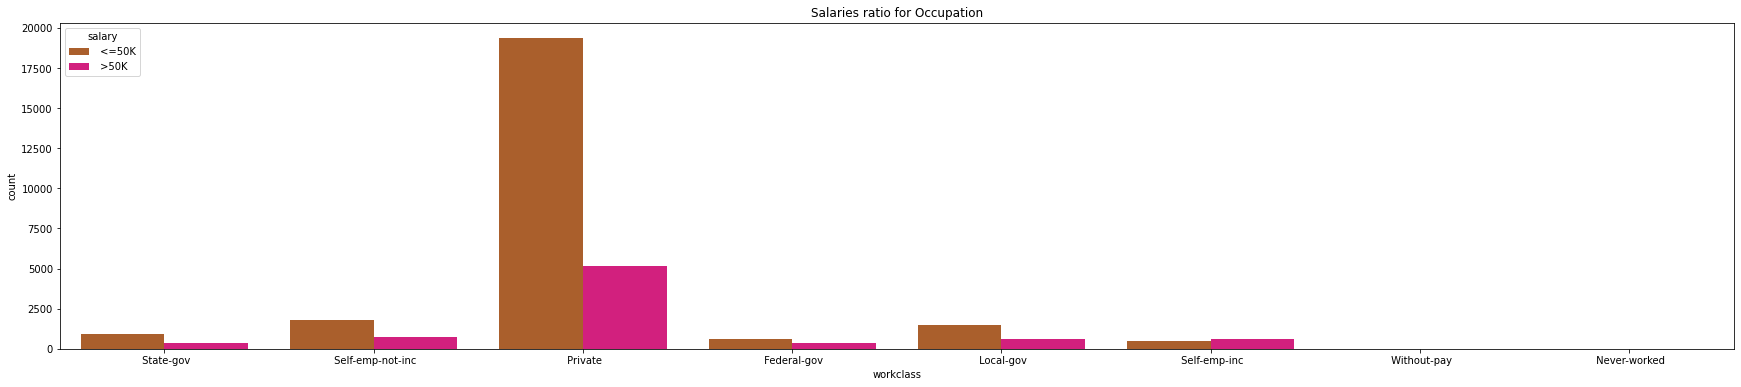

In [31]:
plt.figure(figsize=(30,6))
sns.countplot(data=df, x='workclass', hue='salary' ).set_title('Salaries ratio for Occupation')

---
---
*Bar plot for various occupations in the 2 salary cateogories*

Text(0.5, 1.0, 'Salaries ratio for Occupation')

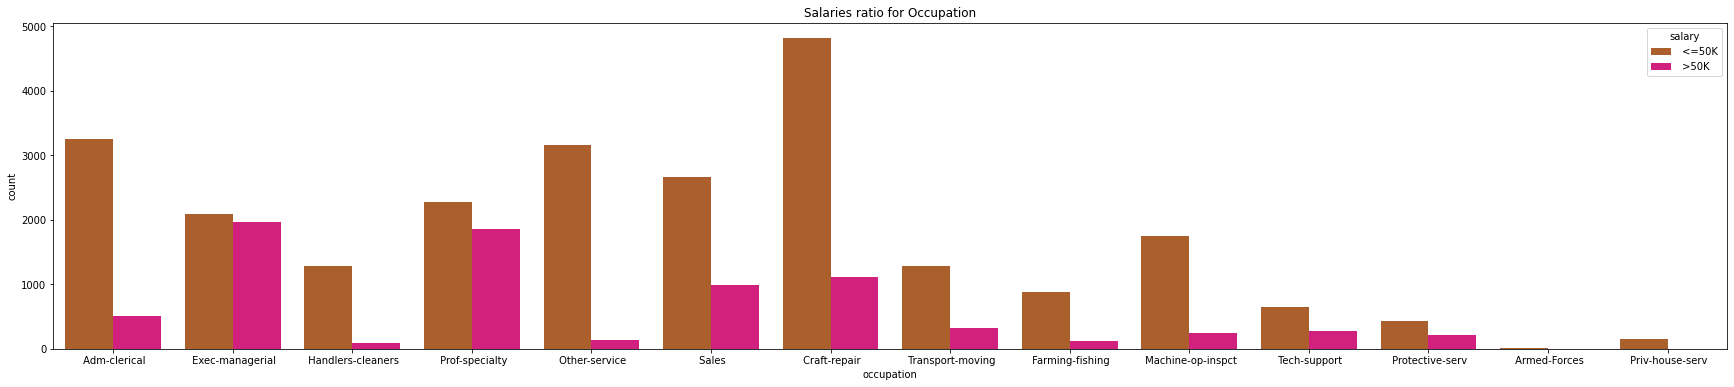

In [32]:
plt.figure(figsize=(30,6))
sns.countplot(data=df, x='occupation', hue='salary' ).set_title('Salaries ratio for Occupation')

we see that some occupations have salary less than 50k for majority of the peoplecraft-repair, adm-clerical). Some have an equal distribution of more and less than 50k salaried people like exec-managerial and prof-speciality.


---
---
*Bar plot for various relationship in the 2 salary cateogories*

Text(0.5, 1.0, 'Salaries ratio for Occupation')

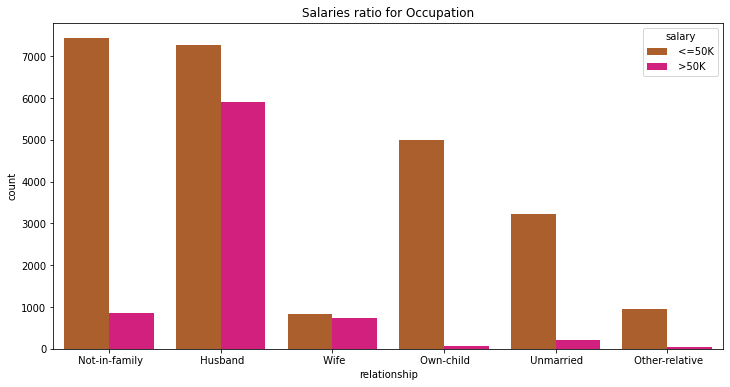

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='relationship', hue='salary' ).set_title('Salaries ratio for Occupation')

Since the Husband/wife is having more equal distribution of salary, we will be moving that into label encoding value 1 and all the others as 0.

In [34]:
df_cleaned=df

In [35]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Feature Engineering

---
---
*Converting target variable to binary value*

In [36]:
df['salary'] = df['salary'].map({' >50K': 1, ' <=50K': 0})
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X['native-country'].value_counts().sort_values(ascending=False).head(20)


 United-States         29735
 Mexico                  639
 Philippines             198
 Germany                 137
 Canada                  121
 Puerto-Rico             114
 El-Salvador             106
 India                   100
 Cuba                     95
 England                  90
 Jamaica                  81
 South                    80
 China                    75
 Italy                    73
 Dominican-Republic       70
 Vietnam                  67
 Japan                    62
 Guatemala                62
 Poland                   60
 Columbia                 59
Name: native-country, dtype: int64

In [37]:
#Find relationship
def get_mutual_information_score(X, y):
    X1 = X.copy()
    # Target variable y discrete
    for i in X1.select_dtypes('object').columns:
        X1[i], _ = X1[i].factorize()
    mi_score = mutual_info_regression(X1, y)
    return pd.Series(mi_score, name='MI Score', index=X1.columns).sort_values(ascending=False)

#categorical Data
def one_hot_encoding_field(dataset, field_name):
    field_one_hot = pd.get_dummies(X[field_name], prefix=f"{field_name}=", prefix_sep="")
    dataset = pd.concat([X, field_one_hot], axis=1)
    dataset = dataset.drop([field_name], axis=1)
    return dataset

#normalizing so that some fields with higher integer values dont unnecessarily skew the model
def normalization_of_numerical(dataset, field_name):
    X[field_name] = X[field_name] / X[field_name].max()
    return X

In [38]:
print(get_mutual_information_score(X, y))

relationship      0.066144
education-num     0.058811
age               0.057368
capital-gain      0.047873
hours-per-week    0.032838
sex               0.029426
marital-status    0.021539
workclass         0.013137
education         0.011476
capital-loss      0.006436
fnlwgt            0.005063
occupation        0.003103
race              0.000000
native-country    0.000000
Name: MI Score, dtype: float64


#### encoding native-country

In [39]:
most_frequent_10 = [x for x in X['native-country'].value_counts().sort_values(ascending=False).head(10).index]
most_frequent_10
for i in most_frequent_10:
  print(i)
  X[i]=np.where(X['native-country']==i,1,0)



 United-States
 Mexico
 Philippines
 Germany
 Canada
 Puerto-Rico
 El-Salvador
 India
 Cuba
 England


In [40]:
# Onehot encoding mapping result
X[['native-country']+most_frequent_10]

,native-country,United-States,Mexico,Philippines,Germany,Canada,Puerto-Rico,El-Salvador,India,Cuba,England
0,United-States,1,0,0,0,0,0,0,0,0,0
1,United-States,1,0,0,0,0,0,0,0,0,0
2,United-States,1,0,0,0,0,0,0,0,0,0
3,United-States,1,0,0,0,0,0,0,0,0,0
4,Cuba,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
32556,United-States,1,0,0,0,0,0,0,0,0,0
32557,United-States,1,0,0,0,0,0,0,0,0,0
32558,United-States,1,0,0,0,0,0,0,0,0,0
32559,United-States,1,0,0,0,0,0,0,0,0,0


#### encoding marital-status

In [41]:
X['marital-status'].value_counts()


 Married-civ-spouse       14970
 Never-married            10667
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [42]:
X['marital-status']=X['marital-status'].replace([' Married-civ-spouse',' Married-spouse-absent',' Married-AF-spouse'],1)
X['marital-status']=X['marital-status'].replace([' Divorced',' Separated',' Widowed'],0)
X['marital-status']=X['marital-status'].replace([' Never-married'],-1)
X['marital-status'].value_counts()


 1    15411
-1    10667
 0     6459
Name: marital-status, dtype: int64

#### Encoding relationship


In [43]:
X['relationship']=X['relationship'].replace([' Husband',' Wife'],1)
X['relationship']=X['relationship'].replace([' Not-in-family',' Unmarried',' Own-child', ' Other-relative'],0)

X['relationship'].value_counts()


0    17782
1    14755
Name: relationship, dtype: int64

In [44]:
### Normalizinng fucntion, onehot encoding function and MutualInformation function

In [45]:
X.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,United-States,Mexico,Philippines,Germany,Canada,Puerto-Rico,El-Salvador,India,Cuba,England
0,39,State-gov,77516,Bachelors,13,-1,Adm-clerical,0,White,Male,...,1,0,0,0,0,0,0,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,1,Exec-managerial,1,White,Male,...,1,0,0,0,0,0,0,0,0,0
2,38,Private,215646,HS-grad,9,0,Handlers-cleaners,0,White,Male,...,1,0,0,0,0,0,0,0,0,0


In [46]:
#normalizing so that some fields with higher integer values dont unnecessarily skew the model
numerical_fields_for_normalization = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

nominal_fields_for_one_hot_encoding=["workclass","occupation","sex","race"]

In [47]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: salary, Length: 32537, dtype: int64

In [48]:
#dropping native-country as if its encoded.

X.drop('native-country', axis=1, inplace=True)

#dropping education as there is an exact mirror field education-num
X.drop('education', axis=1, inplace=True)


In [49]:
X.head(5)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,...,United-States,Mexico,Philippines,Germany,Canada,Puerto-Rico,El-Salvador,India,Cuba,England
0,39,State-gov,77516,13,-1,Adm-clerical,0,White,Male,2174,...,1,0,0,0,0,0,0,0,0,0
1,50,Self-emp-not-inc,83311,13,1,Exec-managerial,1,White,Male,0,...,1,0,0,0,0,0,0,0,0,0
2,38,Private,215646,9,0,Handlers-cleaners,0,White,Male,0,...,1,0,0,0,0,0,0,0,0,0
3,53,Private,234721,7,1,Handlers-cleaners,1,Black,Male,0,...,1,0,0,0,0,0,0,0,0,0
4,28,Private,338409,13,1,Prof-specialty,1,Black,Female,0,...,0,0,0,0,0,0,0,0,1,0


In [50]:
for i in numerical_fields_for_normalization:
    X = normalization_of_numerical(X, i)


In [51]:
#normalizing numerical attributes so that they are equally scaled
for j in nominal_fields_for_one_hot_encoding:
    X = one_hot_encoding_field(X, j)


In [52]:
X

,age,fnlwgt,education-num,marital-status,relationship,capital-gain,capital-loss,hours-per-week,United-States,Mexico,...,occupation= Sales,occupation= Tech-support,occupation= Transport-moving,sex= Female,sex= Male,race= Amer-Indian-Eskimo,race= Asian-Pac-Islander,race= Black,race= Other,race= White
0,0.433333,0.052210,0.8125,-1,0,0.021740,0.0,0.404040,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0.555556,0.056113,0.8125,1,1,0.000000,0.0,0.131313,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0.422222,0.145245,0.5625,0,0,0.000000,0.0,0.404040,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0.588889,0.158093,0.4375,1,1,0.000000,0.0,0.404040,1,0,...,0,0,0,0,1,0,0,1,0,0
4,0.311111,0.227930,0.8125,1,1,0.000000,0.0,0.404040,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.300000,0.173302,0.7500,1,1,0.000000,0.0,0.383838,1,0,...,0,1,0,1,0,0,0,0,0,1
32557,0.444444,0.103976,0.5625,1,1,0.000000,0.0,0.404040,1,0,...,0,0,0,0,1,0,0,0,0,1
32558,0.644444,0.102317,0.5625,0,0,0.000000,0.0,0.404040,1,0,...,0,0,0,1,0,0,0,0,0,1
32559,0.244444,0.135710,0.5625,-1,0,0.000000,0.0,0.202020,1,0,...,0,0,0,0,1,0,0,0,0,1


#### smote sampling


In [53]:
smote=SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [54]:


fig = px.pie(values=y.value_counts(), width=1000, height=300, title="Data Balance")



fig.show()

## Modelling


---
---
*Initializing the 4 models*

In [55]:
decisionTree=DecisionTreeClassifier()
logR = LogisticRegression(random_state=0, max_iter=X.shape[0])
knn = KNeighborsClassifier(n_neighbors=4)
randomModel = RandomForestClassifier()



In [56]:

cross_val_score_decision_tree=cross_val_score(decisionTree,X,y,cv=10,scoring='accuracy').mean()

cross_val_score_KNN=cross_val_score(knn,X,y,cv=10,scoring='accuracy').mean()

cross_val_score_logR=cross_val_score(logR,X,y,cv=10,scoring='accuracy').mean()

cross_val_score_random_forest=cross_val_score(randomModel,X,y,cv=10,scoring='accuracy').mean()


In [57]:
print("The accuracy of Decision Tree accuracy ",cross_val_score_decision_tree)
print("Logistic Regression accuracy ",cross_val_score_logR)
print("KNN accuracy ",cross_val_score_KNN)
print("Random forest accuracy ",cross_val_score_random_forest)

The accuracy of Decision Tree accuracy  0.8556590771788286
Logistic Regression accuracy  0.825026796553581
KNN accuracy  0.8602123231357787
Random forest accuracy  0.8987184378158473


In [58]:
### cross validation prediction

In [59]:
# y_pred_decision_tree = cross_val_predict(decisionTree, X, y, cv=10)
# y_pred_knn = cross_val_predict(knn, X, y, cv=10)
# y_pred_random_logR = cross_val_predict(logR, X, y, cv=10)
# y_pred_random_model = cross_val_predict(randomModel, X, y, cv=10)

---
---
*Function for model Evaluation*

In [60]:
from sklearn import metrics
def model_evaluation(modeName, x_val, y_val):
  #plot_confusion_matrix(modeName,x_val,y_val) // deprecated
  print("\n\n The model evaluation metrics : \n\n")
  prediction=modeName.predict(x_val)
  print("Accuracy of the model is ",metrics.accuracy_score(y_val,prediction))
  print("Recall of the model is ",metrics.recall_score(y_val,prediction))
  print("Precision of the model is ",metrics.precision_score(y_val,prediction))
  print("F1 Score of the model is ",metrics.f1_score(y_val,prediction))
  print("\n\n\n")
  cm=confusion_matrix(y_val,prediction)
  print("\n\n\n")
  plt.figure(figsize = (6,6))
  sns.heatmap(cm, annot=True, cmap= 'flare',  fmt='d', cbar=True)
  plt.xlabel('Predicted_Label')
  plt.ylabel('Truth_Label')
  plt.title('The Confusion Matrix - ')
  


---
---
 *Split the data into test and validation sets*

In [61]:
X_train,X_validaiton, y_train, y_validation=train_test_split(X,y, test_size=0.2 ,shuffle=True, random_state=10)
model_RF=randomModel.fit(X_train,y_train)
#y_pred_random_model = model_RF.predict(X_validaiton)




 The model evaluation metrics : 


Accuracy of the model is  0.8979757085020242
Recall of the model is  0.9218781623153208
Precision of the model is  0.8798531968321421
F1 Score of the model is  0.9003755682941292










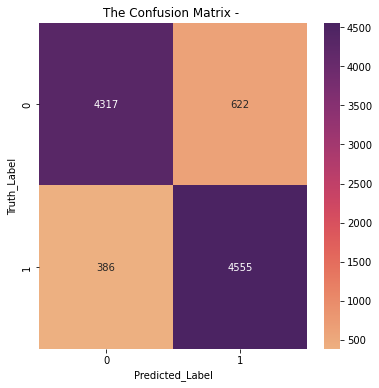

In [62]:
# Model Evaluation for the most acuurate model
model_evaluation(model_RF,X_validaiton,y_validation)

## Deep learning


In [79]:
from keras.layers import Dense
from keras.models import Sequential

In [80]:
dimensions=X_train.shape

In [81]:

model_dnn = Sequential()
model_dnn.add(Dense(32, activation='relu', input_dim=dimensions[1]))
model_dnn.add(Dense(16, activation='relu'))
model_dnn.add(Dense(16, activation='relu'))

# since this is a classification project, output layer activation function is Sigmoid
model_dnn.add(Dense(1, activation='sigmoid'))
model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [82]:
dnn=model_dnn.fit(X_train, y_train, epochs=200, verbose=False)

In [83]:
accuracy_score_dnn_train_data=model_dnn.evaluate(X_train,y_train, verbose=False)
accuracy_score_dnn_test_data=test_score_dnn=model_dnn.evaluate(X_validaiton,y_validation, verbose=False)


In [84]:
print("\nAccuracy on the training dataset is: %.2f%%\n" % (accuracy_score_dnn_train_data[1]*100))
print("\n\nAccuracy on the testing dataset is: %.2f%%\n" % (accuracy_score_dnn_test_data[1]*100))


Accuracy on the training dataset is: 87.04%



Accuracy on the testing dataset is: 84.67%



In [85]:
p_pred=model_dnn.predict(X_validaiton)
#p_pred = p_pred.flatten()
#prediction_dnn = np.where(p_pred > 0.5, 1, 0)



309/309 [==============================] - 1s 3ms/step


In [72]:
print(p_pred.round(2))

[[0.2 ]
 [0.04]
 [0.65]
 ...
 [0.83]
 [0.05]
 [0.  ]]


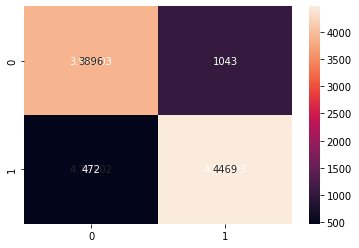

In [94]:
dnn_c_matrix = confusion_matrix(y_validation, np.round(p_pred))
ax = sns.heatmap(dnn_c_matrix, annot=True, xticklabels=['Less than 50k', 'More than 50k'], yticklabels=['Less than 50k', 'More than 50k'], cbar=False, cmap='Blues')

#Turning off scientific notation
sns.heatmap(dnn_c_matrix,annot=True, fmt='g')

# ax.set_xlabel("Predicted result")
# ax.set_ylabel("Actual data")


# plt.show()
# plt.clf()

In [ ]:
print(classification_report(y_validation, np.round(p_pred)))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      4939
           1       0.84      0.83      0.83      4941

    accuracy                           0.83      9880
   macro avg       0.83      0.83      0.83      9880
weighted avg       0.83      0.83      0.83      9880



Rewriting random forest evaluation for comapring with the Deep neural network



 The model evaluation metrics : 


Accuracy of the model is  0.8979757085020242
Recall of the model is  0.9218781623153208
Precision of the model is  0.8798531968321421
F1 Score of the model is  0.9003755682941292










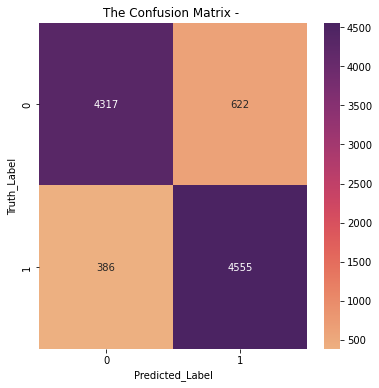

In [95]:

model_evaluation(model_RF,X_validaiton,y_validation)



---



---



---


**We found out that Random forest still has the better performace with respect to accuracy, precision, recall and F1 values**